# MAKE A COPY BEFORE PULLING RESULTS FROM GUANACO

# Parameters to experiment

In [1]:
# training on guanaco
trainingOnGuanaco = False

# number_experiment (this is just a name)
# priors:
# 1
number_experiment = 3
number_experiment = str(number_experiment)

In [2]:
# classes to analyze
# 42,  90,  16,  67,  62, 993,  92,  52,  88,  65, 991, 992,  15,
#        95,   6,  53, 994,  64
# only_these_labels = [16, 92, 53]
only_these_labels = [92]
# only_these_labels = [42,  90,  16,  67,  62, 993,  92,  52,  88,  65, 991, 992,  15,
#         95,   6,  53, 994,  64]

# VAE parameters
latentDim = 100
hiddenDim = 100
inputDim = 72
# training
epochs = 100

# band
# passband = 5
passband = 1

batch_training_size = 128

# Import libraries

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import torch
from torch.utils import data

# from tqdm import tqdm_notebook

# %matplotlib inline
%matplotlib notebook

# import functions to load dataset
import sys
sys.path.append("./codesToDatasets")
from plasticc_dataset_torch import get_plasticc_datasets
# from plasticc_plotting import plot_light_curve

# Load data

In [4]:
# define path to dataset

pathToFile = "/home/shared/astro/PLAsTiCC/" if trainingOnGuanaco else "/home/leo/Downloads/plasticc_torch/"
# path to file in guanaco
# pathToFile = "/home/shared/astro/PLAsTiCC/"

# path to file in local 
# pathToFile = "/home/leo/Downloads/plasticc_torch/"

## Loading dataset with pytorch tool

In [5]:
# torch_dataset_lazy = get_plasticc_datasets(pathToFile)

# Light curves are tensors are now [bands, [mjd, flux, err, mask],
# lc_data, lc_label, lc_plasticc_id                              
torch_dataset_lazy = get_plasticc_datasets(pathToFile, only_these_labels=only_these_labels)

You have selected lazy loading. Light curves will be loaded ondemand from the harddrive
Found 1 csv files at given path
Loading /home/leo/Downloads/plasticc_torch/plasticc_train_lightcurves.csv


# Ploting one light curve

In [6]:
# lc_data, lc_label, lc_plasticc_id = torch_dataset_lazy.__getitem__(123)
# display(lc_plasticc_id, lc_label)
# 6 bands: u g r i z Y
# 4 sequences: mjd, flux, error, mask
# 72 samples
# display(lc_data.shape, lc_data.dtype)
# print(lc_data.detach().numpy()[0, 0, :])

In [7]:
# plot_light_curve(torch_dataset_lazy, index_in_dataset=1234)

# Spliting data (train/test)

In [8]:
print(torch_dataset_lazy.__len__())
import math

print(int(0.8 * torch_dataset_lazy.__len__()))

print(math.floor(0.8*torch_dataset_lazy.__len__()/2))

print(math.ceil(0.8*torch_dataset_lazy.__len__()/2))



239
191
95
96


In [9]:
# Spliting the data

# print(torch_dataset_lazy.__len__())

# selecting train splitting
train_size = int(0.8 * torch_dataset_lazy.__len__())
#print(train_size)

# getting test splitting
validation_size = math.floor((torch_dataset_lazy.__len__() - train_size)/2)
#print(validation_size)

# getting test splitting
test_size = torch_dataset_lazy.__len__() - train_size - validation_size
#print(test_size)

# spliting the torch dataset
trainDataset, validationDataset,  testDataset = torch.utils.data.random_split(torch_dataset_lazy, [train_size, validation_size, test_size])

print("train size:", train_size)
print("validation size: ", validation_size)
print("test size:", test_size)
print("sum: ", train_size+ validation_size + test_size)

train size: 191
validation size:  24
test size: 24
sum:  239


## Create a dataloader

In [10]:
# # Create data loader (minibatches)

# # train loader
trainLoader = torch.utils.data.DataLoader(trainDataset, batch_size= batch_training_size, shuffle=True, num_workers = 4)

# validation loader
validationLoader = torch.utils.data.DataLoader(validationDataset, batch_size= batch_training_size, shuffle=True, num_workers = 4)

# # test loader
testLoader = torch.utils.data.DataLoader(testDataset)
# trainLoader = torch.utils.data.DataLoader(torch_dataset_lazy, batch_size=256, shuffle=True, num_workers=0)

## Load the path to save model while training

In [11]:
import os

# create experiment's folder
folder_path = ("/home/lbravo/thesis/work/thesis/experiments/" + number_experiment) if trainingOnGuanaco else ("/home/leo/Desktop/thesis/work/thesis/experiments/" + number_experiment)
# !mkdir folder_path
# os.makedirs(os.path.dirname(folder_path), exist_ok=True)

# check if folder exists
if not(os.path.isdir(folder_path)):
        
    # create folder
    try:
        os.mkdir(folder_path)
    except OSError:
        print ("Creation of the directory %s failed" % folder_path)
    else:
        print ("Successfully created the directory %s " % folder_path)
else:
    print("folder already exists")

# define paht to save model while training
pathToSaveModel = "/home/lbravo/thesis/work/thesis/experiments/" + number_experiment + "/model" if trainingOnGuanaco else "/home/leo/Desktop/thesis/work/thesis/experiments/" + number_experiment + "/model"

folder already exists


# Save dataset description

In [12]:
# # check data loader shape
# text_file = open("experiments/" + number_experiment + "/datasetDescription.txt", "w")

# # training
# text_file.write("#### TRAINING ####")
# text_file.write("\nminibatches trainig: "+ str(len(list(trainLoader))))
# text_file.write("\nminibatch trainig size: " + str(list(trainLoader)[0][0].shape))


# # testing
# text_file.write("\n#### TESTING ####")
# text_file.write("\nminibatches test: "+ str(len(list(testLoader))))
# text_file.write("\nminibatch trainig size: " + str(list(testLoader)[0][0].shape))

# text_file.close()

## Define autoencoder structure
To start with the work, It is going to build a very basic Autoencoder

In [13]:
# Buiding autoencoder

# Assuming this has a normal distrubtion in the latent part

# encoder
class Encoder(torch.nn.Module):
    
    # init method
    def __init__(self, latent_dim, hidden_dim, input_dim):

        super(Encoder, self).__init__()
        
        # 1 Convolution layer
        # Conv1d(input channel, output channel, kernel size)
        self.conv1 = torch.nn.Conv1d(1,64,3)
        
        # this is to consider time and magnitude
        # we should use shared weights?
        self.conv1Time = torch.nn.Conv1d(1, 64, 3)
        self.conv1Mag = torch.nn.Conv1d(1, 64, 3)
        
        # 2 Convolution layer
        # Conv1d(input channel, output channel, kernel size)
        self.conv2 = torch.nn.Conv1d(64, 32, 3)
        
        # time and magnitude conv
        self.conv2Time = torch.nn.Conv1d(64, 32, 3)
        self.conv2Mag = torch.nn.Conv1d(64, 32, 3)
        
        # linear layer
        self.hidden1 = torch.nn.Linear(2144*2, hidden_dim)
        
        self.hidden2 = torch.nn.Linear(hidden_dim, hidden_dim)
        
        # mu
        self.mu = torch.nn.Linear(hidden_dim, latent_dim)
        
        # sigma
        self.logVar = torch.nn.Linear(hidden_dim, latent_dim)
        
        # activation function
#         self.activationConv = torch.nn.ReLU() #max(0, x)
        self.activationConv = torch.nn.Tanh() #max(0, x)
    
        self.activationLinear = torch.nn.Tanh()

    # forward method
    def forward(self, x):
        
        # input shape: [batch_size, channels, sequence_length]
        # print("input shape: {0}".format(x.shape))
        
        
        # convolution 1
        # x -> conv -> act -> ouput
        # shape should be: [batch_size, number of ouput channels (64), length of output from convolution]

        #conv to time
        outputTimeConv = self.activationConv(self.conv1Time(x[:, 0, :].unsqueeze(1)))
        
        # conv to magnitude
        outputMagConv = self.activationConv(self.conv1Mag(x[:, 1, :].unsqueeze(1)))
        
#         print("output conv1 shape: {0}".format(outputMagConv.shape))
#         print("output conv1 shape: {0}".format(outputTimeConv.shape))
        
        # convolution 2
#         # shape should be: [batch_size, number of ouput channels (32), length of output from convolution]
        
        # conv to time
        outputTimeConv = self.activationConv(self.conv2(outputTimeConv))
    
        # conv to flux
        outputMagConv = self.activationConv(self.conv2(outputMagConv))
        
#         print("output conv2 shape: {0}".format(outputTimeConv.shape))
#         print("output conv2 shape: {0}".format(outputMagConv.shape))
        
        # flatten ouput
        # shape should be: [batch_size, -1]
        outputMagConv = outputMagConv.view(outputMagConv.shape[0], -1)
        outputTimeConv = outputTimeConv.view(outputTimeConv.shape[0], -1)
        
#         print("output reshape: ", outputMagConv.shape)
#         print("output reshape: ", outputTimeConv.shape)
                
        # concatenate 2 towers
        output = torch.cat((outputMagConv, outputTimeConv), 1)
#         print("concatenate output shape: ", output.shape)
        
        # x -> hidden1 -> activation
        output = self.activationLinear(self.hidden1(output))
        
#         second hidden layer
        output = self.activationLinear(self.hidden2(output))
        output = self.activationLinear(self.hidden2(output))
    
#         output = self.hidden1(output)
#         print("hidden1 output shape: {0}".format(output.shape))
        
        # get mu
        # sin tangenteh!!!
        mu = self.mu(output)
#         print("mu shape: {0}".format(mu.shape))
        
        # get sigma
        logVar = self.logVar(output)
#         print("sigma shape: {0}".format(logVar.shape))
        
        # returning values
        return mu, logVar

    
# decoder    
class Decoder(torch.nn.Module):
    
    # define layers
    def __init__(self, latent_dim, hidden_dim, output_dim):
        
        super(Decoder, self).__init__()
        
        # linear layer
        self.hidden1 = torch.nn.Linear(latent_dim, 2144*2)
        
        # 1 ConvolutionTrans layer
        self.convTrans1 = torch.nn.ConvTranspose1d(32, 64, 3)
        
        # 2 ConvolutionTrans layer
        self.convTrans2 = torch.nn.ConvTranspose1d(64, 1, 3)

        # activation function
#         self.activationConv = torch.nn.ReLU() #max(0, x)
        self.activationConv = torch.nn.Tanh() #max(0, x)
    
        self.activationLinear = torch.nn.Tanh()
        
    # forward method
    def forward(self, z):
        
#         print("input dimension decoder: {0}".format(z.shape))
        
        # linear (from latent to hidden dimension)
        # z -> linaer layer -> activation -> output
        output = self.activationLinear(self.hidden1(z))
#         print("output hidden1: {0}".format(output.shape))
        
        # split data (into time and flux)
        outputTimeDeconv, outputMagDeconv = torch.split(output, 2144, dim=2)
            
        # reshape each tower (time and magnitude)
        outputTimeDeconv = outputTimeDeconv.view(outputTimeDeconv.shape[0], 32, -1)
        outputMagDeconv = outputMagDeconv.view(outputMagDeconv.shape[0], 32, -1)
        
#         print("output reshape: {0}".format(outputTimeDeconv.shape))
#         print("output reshape: {0}".format(outputMagDeconv.shape))
        
        # 1 convolution
        outputTimeDeconv = self.activationConv(self.convTrans1(outputTimeDeconv))
        outputMagDeconv = self.activationConv(self.convTrans1(outputMagDeconv))
#         print("ouput convTrans1: {0}".format(outputTimeDeconv.shape))
#         print("ouput convTrans1: {0}".format(outputMagDeconv.shape))
        
        # 2 convolution
        outputTimeDeconv = self.convTrans2(outputTimeDeconv)
        outputMagDeconv = self.convTrans2(outputMagDeconv)
        
#         print("ouput convTrans2: {0}".format(outputTimeDeconv.shape))
#         print("ouput convTrans2: {0}".format(outputMagDeconv.shape))
        
        # concatenate arrays in order to get the data with 2 channels
        output = torch.cat((outputTimeDeconv, outputMagDeconv), 1)
#         print("concatenate in channels: {0}".format(output.shape))

        # output
        return output

# building the autoencoder     
class AutoEncoder(torch.nn.Module):
    
    # defining the initial structure
    def __init__(self, latent_dim, hidden_dim, input_dim):
        
        super(AutoEncoder, self).__init__()
        
        # defining the encoder
        self.encoder = Encoder(latent_dim, hidden_dim, input_dim)
        
        # defining the decoder
        # note the output dimension in the decoder is the same as input dimension
        self.decoder = Decoder(latent_dim, hidden_dim, input_dim)

    # distribution function
    def sampling(self, mu, logvar, k = 1):
        
        # assumming normal distribution
#         s = torch.exp(0.5*sigma)
#         eps = torch.rand_like(s) # generate a iid standard normal same shape as s
#         return eps.mul(s).add_(mu)
        batch_size, n_latent = logvar.shape
        std = (0.5*logvar).exp()
#         eps = torch.randn(batch_size, k, n_latent, device=std.device, requires_grad=False)
        eps = torch.randn(batch_size, k, n_latent, requires_grad=False)
        if "cuda" in str(mu.device):
            eps = eps.cuda()
        return eps.mul(std.unsqueeze(1)).add(mu.unsqueeze(1))
    
    def get_latent_variables(self, x):
        
        # get mu and logvar
        mu, logVar = self.encoder(x)
        
        # sampling to get the latent variables
        z = self.sampling(mu, logVar)
        
        # return values
        return z
    
    # forward method (how to the nn works)
    def forward(self, x):
        
#         print("input size: {0}".format(x.shape))
        
#         print("## Encoder ##")
        # input (x) -> encoder -> latent variables
        mu, logVar = self.encoder(x)
#         print("output encoder size: {0}".format(mu.shape))
        
#         print("mu ", mu.device)
#         print("var ", logVar.device)
        # getting sample
        # mu, sigma -> distribution -> z
        z = self.sampling(mu, logVar)
#         print("z shape: ", z.shape)
        
#         print("## Dencoder ##")
        # latent variables -> decoder -> reconstruction (x)
        decOutput = self.decoder(z)
#         print("output decoder size: {0}".format(decOutput.shape))
        
        # agregar mu, logvar, decOutput
        return decOutput, mu, logVar

## Defining parameters to Autoencoder

In [14]:
# check number of parameters
# latentDim = 5
# hiddenDim = 10
# inputDim = 72

latentDim = latentDim
hiddenDim = hiddenDim
inputDim = inputDim

passband = passband

# defining model
model = AutoEncoder(latent_dim = latentDim, hidden_dim = hiddenDim, input_dim = inputDim)

In [15]:
# # test the model data flow
# model.forward(list(trainLoader)[0][0]).shape

In [16]:
# # print("input dimension: {0}".format(len(list(trainLoader))))

# # parameters number
# count = 0

# # # check model dimension
# for name, param in model.state_dict().items():
#     # name: str
#     # param: Tensor
# #     print("{0}: {1} \n".format(name, param.shape))
# #     print(param.shape[0]*(param.shape[1] if len(param.shape)>1 else 1))
# #     print(param.shape)
#     count += param.shape[0]*(param.shape[1] if len(param.shape)>1 else 1)
# # for param in model.parameters():
    
# print("number of parameters: " + str(count))

In [17]:
def generate_delta_mask(mask):
    
#     print("mask; ", mask.shape)
    
#     print("mask 1: : ", mask[1:].type(torch.BoolTensor))
    
#     print("mask :-1 : ", mask[:-1].type(torch.BoolTensor))
    
    
    mask_delta = mask[:, 1:].type(torch.BoolTensor) & mask[:, :-1].type(torch.BoolTensor)

#     print("mask delta: ", mask_delta.shape)
    
    return mask_delta

In [18]:
from torch.nn import functional as F

# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(recon_x, x, mu, logvar, mask):
    
#     print("reconstruction: {0}".format(recon_x))
#     print("x: {0}".format(x))
#     print("mu: {0}".format(mu))
#     print("logvar: {0}".format(logvar))
    
#     print(recon_x.shape)
#     print(x.shape)
    
#     print("before mask: ", mask)
    mask = generate_delta_mask(mask).cuda()
#     print("after mask: ", mask)
#     print("loss shape: ", F.mse_loss(recon_x, x, reduction='none').shape)
#     BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')

    # this one is the normal (considering all datapoints)
#     BCE = F.mse_loss(recon_x, x, reduction='sum')
    # BCE  = [128, 2, 71]
    
    # this is considering mask
    BCE = F.mse_loss(recon_x, x, reduction='none')
#     print(F.mse_loss(recon_x, x, reduction='none').shape)
    BCE[:, 0, :] = BCE[:, 0, :] * mask
    BCE[:, 1, :] = BCE[:, 1, :] * mask
#     print(BCE.shape)
    # reducttion 
    BCE = torch.sum(BCE) / (BCE.shape[0]*BCE.shape[1]*BCE.shape[2])

#     print("BCE: ", BCE)
    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
#     print("KLD: ", KLD)
#     print(BCE)
    
    return BCE + KLD
#     return BCE

In [19]:
# normalize light curve
# data: [batch size, 2 channels (time and magnitude), light curve length]
def normalizeLightCurve(data):
    
#     print("data shape before normalization: ", data.shape)
    
    # get flux mean
    means = data[:, 1, :].mean(dim=1)
#     print("mean shape: ", means.shape)
    
    # get flux standar deviation 
    stds = data[:, 1, :].std(dim=1)
#     print("stds shape: ", stds.shape)
    
    # overwrite flux
    data[:, 1, :] = (data[:, 1, :] - means.unsqueeze(1).expand_as(data[:, 1, :])) / stds.unsqueeze(1).expand_as(data[:, 1, :])
#     print("normalized data shape: ", data.shape)
    
    # return normalized data
    return data

In [20]:
# function to generate delta time and flux
# data = [batchSize, channels, [time, flux, err, mask], light curve]
def generateDeltas(data, passBand):
    
    # work with delta time and magnitude
    
#     print("generate deltas input shape: {0}".format(data.shape) )
    # delta time
    tmpDeltaTime = data[:, passBand, 0, 1:] - data[:, passBand, 0, :-1]

#     print("generate deltas time shape: {0}".format(tmpDeltaTime.shape) )

#     # delta magnitude
    tmpDeltaMagnitude = data[:, passBand, 1, 1:] - data[:, passBand, 1, :-1]
#     print("generate deltas flux shape: {0}".format(tmpDeltaMagnitude.shape))
    
    # concatenate tensors
    dataToUse = torch.cat((tmpDeltaTime.unsqueeze(1), tmpDeltaMagnitude.unsqueeze(1)), 1)
#     print("data to use shape: {0}".format(dataToUse.shape))
    
    # normalize data
    dataToUse = normalizeLightCurve(dataToUse)
    
    # returning data
    return dataToUse

### Training

<IPython.core.display.Javascript object>


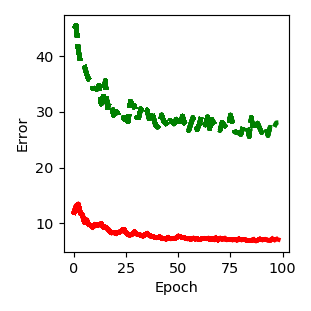

starting the training
epoch:    0 / 100
early stopping counter:  2
New min test loss. Saving model
saving losses
epoch:    1 / 100
early stopping counter:  4
saving losses
epoch:    2 / 100
New min test loss. Saving model
saving losses
epoch:    3 / 100
New min test loss. Saving model
saving losses
epoch:    4 / 100
New min test loss. Saving model
saving losses
epoch:    5 / 100
New min test loss. Saving model
saving losses
epoch:    6 / 100
New min test loss. Saving model
saving losses
epoch:    7 / 100
New min test loss. Saving model
saving losses
epoch:    8 / 100
New min test loss. Saving model
saving losses
epoch:    9 / 100
New min test loss. Saving model
saving losses
epoch:    10 / 100
New min test loss. Saving model
saving losses
epoch:    11 / 100
New min test loss. Saving model
saving losses
epoch:    12 / 100
early stopping counter:  2
saving losses
epoch:    13 / 100
New min test loss. Saving model
saving losses
epoch:    14 / 100
early stopping counter:  2
saving losses
e

In [21]:
# loss function
# criterion = torch.nn.MSELoss(reduction = "sum")

# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

# use of GPU flag
use_gpu = True

# load model on GPU
if use_gpu:
    model = model.cuda()

# number of epochs
epochs = epochs

# loss
train_loss = np.zeros((epochs,))
test_loss = np.zeros((epochs,))

# min global test loss 
minTestLossGlobalSoFar = float("inf")

# # # loss plot
fig, ax = plt.subplots(figsize = (3, 3), tight_layout = True)
# # fig, ax = plt.subplots()
ax.set_xlabel("Epoch")
ax.set_ylabel("Error")

# plt.legend()

# plt.axis([0,1000,0,10])
# plt.show()

# early stopping
prior_test_error = 0
count_early_stop = 0
threshold_early_stop = 20

print("starting the training")

for nepoch in range(epochs):
        
    print("epoch:    {0} / {1}".format(nepoch, epochs))
    
#     print("\r{0}".format((float(nepoch)/epochs)*100))
#     sys.stdout.write('\r')
#     # the exact output you're looking for:
#     sys.stdout.write("[%-20s] %d%%" % ('='*nepoch, 5*nepoch))
#     sys.stdout.flush()
#     sleep(0.25)
    
    # train
    epoch_train_loss = 0
    
    for data_ in trainLoader:
        
        data = data_[0]
        
        optimizer.zero_grad()
        
        if use_gpu:
            
#             data = data.type(torch.FloatTensor).cuda()
            data = generateDeltas(data, passband).type(torch.FloatTensor).cuda()
#             print(data.device)
#             print(model.device())
            outputs, mu, logvar = model.forward(data)
    
#             # DO one fortwar!!
#             mu, logvar = model.encoder.forward(data.type(torch.FloatTensor).cuda())
            
        else:
                        
            data = generateDeltas(data, passband).type(torch.FloatTensor)
#             generateDeltas(data, 0)
#             outputs = model.forward(data.type(torch.FloatTensor))
            outputs, mu, logvar = model.forward(data)
#             mu, logvar = model.encoder.forward(data.type(torch.FloatTensor))
        
#         loss = criterion(outputs, data)
        # use KLD + MSE
#         loss = loss_function(outputs, data, mu, logvar)
        loss = loss_function(outputs, data, mu, logvar, data_[0][:, passband, 3, :])
#         print(loss)
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()
    
    train_loss[nepoch] = epoch_train_loss / train_size
    
    # test
    epoch_test_loss = 0
    
    for data_ in validationLoader:
        
        data = data_[0]
        
        if use_gpu:
            
            data = generateDeltas(data, passband).type(torch.FloatTensor).cuda()
#             data = data.type(torch.FloatTensor).cuda()
#             outputs = model.forward(data)
#             mu, logvar = model.encoder.forward(data.type(torch.FloatTensor).cuda())
            outputs, mu, logvar = model.forward(data)
        
        else:
#             data = data.type(torch.FloatTensor)
            data = generateDeltas(data, passband).type(torch.FloatTensor)
            
#             outputs = model.forward(data)
            
#             mu, logvar = model.encoder.forward(data.type(torch.FloatTensor))
            outputs, mu, logvar = model.forward(data)
        
#         loss = criterion(outputs, data)
#         loss = loss_function(outputs, data, mu, logvar)
        loss = loss_function(outputs, data, mu, logvar, data_[0][:, passband, 3, :])
        
        epoch_test_loss += loss.item()
    
    test_loss[nepoch] = epoch_test_loss / test_size
    
# #     # plot loss
    ax.plot(train_loss[0: nepoch], label = "train", linewidth = 3, c = "red") 
    ax.plot(test_loss[0: nepoch], label = "test", linestyle = "--", linewidth = 3, c = "green") 
    
    fig.canvas.draw()
    
    #### Early stopping #####
    
    # if new test loss is greater than the older one
    count_early_stop += 1
    if epoch_test_loss > prior_test_error:
        count_early_stop += 1
        print("early stopping counter: ", count_early_stop)
    else: 
        count_early_stop = 0
    
    # update prior test error
    prior_test_error = epoch_test_loss
    
    # analyze early stopping
    if count_early_stop > threshold_early_stop:
        
        print("Early stopping in epoch: ", nepoch)
        text_file = open("experiments/" + number_experiment + "/earlyStopping.txt", "w")
        metricsText = "Epoch: {0}\n ES counter: {1}\n, Reconstruction test error: {2}".format(nepoch, count_early_stop, epoch_test_loss)
        text_file.write(metricsText)
        text_file.close()
        break
        
    #### Saving best model ####
    
    # if epoch test loss is smaller than global min
    if epoch_test_loss < minTestLossGlobalSoFar:
        
        print("New min test loss. Saving model")
#         print("old: ", minTestLossGlobalSoFar)
#         print("new: ", epoch_test_loss)
        
        # save model
        torch.save(model.state_dict(), pathToSaveModel)
        
        # update global min
        minTestLossGlobalSoFar = epoch_test_loss
        
        # write metrics
        text_file = open("experiments/" + number_experiment + "/bestScoresModelTraining.txt", "w")
        metricsText = "Epoch: {0}\n Reconstruction test error: {1}".format(nepoch, minTestLossGlobalSoFar)
        text_file.write(metricsText)
        text_file.close()

        
    # save losses
    print("saving losses")
    losses = np.asarray([train_loss, test_loss]).T
    np.savetxt("experiments/" + number_experiment + "/training_losses.csv", losses, delimiter=",")
    
    
print("training has finished")

# Analyzing training

<IPython.core.display.Javascript object>


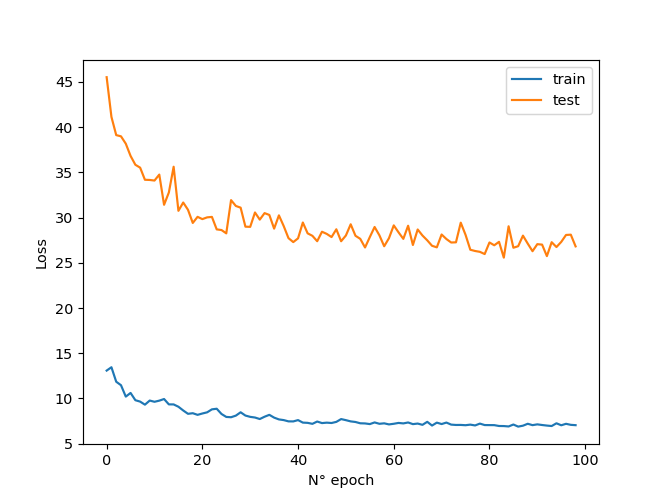

In [22]:

# load losses array
losses = pd.read_csv("/home/leo/Desktop/thesis/work/thesis/experiments/"+ number_experiment + "/training_losses.csv")

# plot losses
fig, ax = plt.subplots()

# axis
ax.set_xlabel("N° epoch")
ax.set_ylabel("Loss")

# plot
ax.plot(losses.iloc[:, 0], label = "train")
ax.plot(losses.iloc[:, 1], label = "test")
ax.legend()

# Classification using Latent variables

## Import libraries 

## Take the data to use to classify

In [23]:
# # Create data loader (minibatches)

# # train loader
# trainLoader = torch.utils.data.DataLoader(trainDataset)

# # # test loader
# testLoader = torch.utils.data.DataLoader(testDataset)
# # trainLoader = torch.utils.data.DataLoader(torch_dataset_lazy, batch_size=256, shuffle=True, num_workers=0)

## Get best model

In [24]:
!cat experiments/1/bestScoresModelTraining.txt

Epoch: 26
 Reconstruction test error: 209693751050752.0

In [25]:
# model.load_state_dict(torch.load(PATH))

# defining model
model = AutoEncoder(latent_dim = latentDim, hidden_dim = hiddenDim, input_dim = inputDim)

# model = TheModelClass(*args, **kwargs)
model.load_state_dict(torch.load(pathToSaveModel))

model.cuda()

AutoEncoder(
  (encoder): Encoder(
    (conv1): Conv1d(1, 64, kernel_size=(3,), stride=(1,))
    (conv1Time): Conv1d(1, 64, kernel_size=(3,), stride=(1,))
    (conv1Mag): Conv1d(1, 64, kernel_size=(3,), stride=(1,))
    (conv2): Conv1d(64, 32, kernel_size=(3,), stride=(1,))
    (conv2Time): Conv1d(64, 32, kernel_size=(3,), stride=(1,))
    (conv2Mag): Conv1d(64, 32, kernel_size=(3,), stride=(1,))
    (hidden1): Linear(in_features=4288, out_features=100, bias=True)
    (hidden2): Linear(in_features=100, out_features=100, bias=True)
    (mu): Linear(in_features=100, out_features=100, bias=True)
    (logVar): Linear(in_features=100, out_features=100, bias=True)
    (activationConv): Tanh()
    (activationLinear): Tanh()
  )
  (decoder): Decoder(
    (hidden1): Linear(in_features=100, out_features=4288, bias=True)
    (convTrans1): ConvTranspose1d(32, 64, kernel_size=(3,), stride=(1,))
    (convTrans2): ConvTranspose1d(64, 1, kernel_size=(3,), stride=(1,))
    (activationConv): Tanh()
    

# Reconstruct light curves

In [26]:
reconstructedLightCurves = np.zeros(shape = (test_size, 2, 72 ))
originalLightCurves = np.zeros(shape = (test_size, 2, 72 ))
mask = np.zeros(shape = (test_size, 72))

# print(test_size)
# print(reconstructedLightCurves.shape)

lastIndex = -1


for i, data_ in enumerate(testLoader):

    data = data_[0]
    
#     print(data.shape)
    
#     print(data[0, passband, 1, :].shape)
    
    data = generateDeltas(data, passband).type(torch.FloatTensor).cuda()
    
#     print("data: ", data.shape)
    
#     outputs = model(data)
    outputs, mu, logvar = model.forward(data)
            
    # save orignial light curve
    originalLightCurves[lastIndex + 1 : (lastIndex + outputs.shape[0] + 1), :, : ] = data_[0][:, passband, 0:2, :]
    mask[lastIndex + 1 : (lastIndex + outputs.shape[0] + 1),] = data_[0][:, passband, 3, :]
    
#     print("original: ", originalLightCurves)
#     print("data: ", data_[0])
#     originalLightCurves = np.append(originalLightCurves, data[:, passband, 0:2, :])

#     # reconstructed data
#     print("output: ", outputs.shape)
    
    reconstructedLightCurve = np.zeros(shape = data_[0][:, passband, 0:2, :].shape)
    
#     print(reconstructedLightCurve.shape)
    
    # convert from delta to original format
    
    # adding first element (index 0)
    # adding time with index 0
    reconstructedLightCurve[:, 0, 0] = data_[0][:, passband, 0, 0]
#     print(reconstructedLightCurve)
    # adding flux with index 0
    reconstructedLightCurve[:, 1, 0] = data_[0][:, passband, 1, 0]
    
    # converting from 1 to end
    for i_lightCurve in range(1, data_[0].shape[3]):
        
        # add time and flux 
        reconstructedLightCurve[:, :, i_lightCurve] = reconstructedLightCurve[:, :, i_lightCurve-1] + outputs[:, :, i_lightCurve-1].cpu().detach().numpy()
        
#     # plotting a light curve
#     if i == 200:
        
#         # create plot
#         fig, ax = plt.subplots(1, 1, figsize = (3,3), tight_layout = True)
#         # add original
#         ax.scatter(data_[0][0, passband, 0, :], data_[0][0, passband, 1, :], label = "original")
#         ax.scatter(reconstructedLightCurve[0, 0, :], reconstructedLightCurve[0, 1, :])
        
    # add lightcurves from batch to array
#     print(reconstructedLightCurves.shape)
#     print(reconstructedLightCurves[lastIndex + 1 : (lastIndex + outputs.shape[0] + 1), :, : ].shape)
    reconstructedLightCurves[lastIndex + 1 : (lastIndex + outputs.shape[0] + 1), :, : ] = reconstructedLightCurve
#     print(lastIndex)
#     print(lastIndex + 1, (lastIndex + outputs.shape[0] + 1))
    
    lastIndex = i*outputs.shape[0] + outputs.shape[0] - 1

<IPython.core.display.Javascript object>


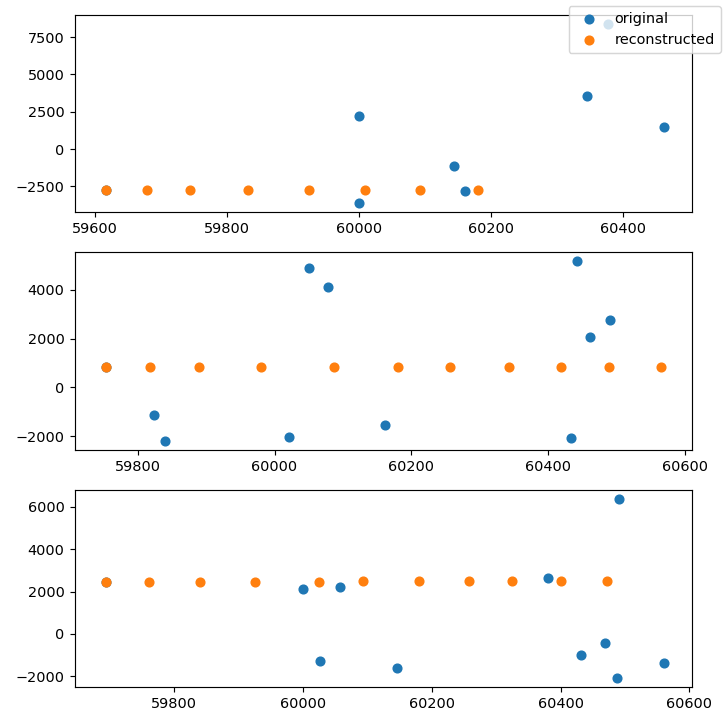

In [27]:
# plot light curves
n_lightCurves = 3

# create random indexes
indexes = np.random.randint(test_size, size= n_lightCurves)

# create plot
fig, ax = plt.subplots(n_lightCurves, 1, figsize = (7,7), tight_layout = True)

# plot light curves
for i in range(n_lightCurves):
    
    # add original
    ax[i].scatter(originalLightCurves[indexes[i], 0, mask[indexes[i]].astype(bool)], originalLightCurves[indexes[i], 1, mask[indexes[i]].astype(bool)], label = "original")
    ax[i].scatter(reconstructedLightCurves[indexes[i], 0, mask[indexes[i]].astype(bool)], reconstructedLightCurves[indexes[i], 1, mask[indexes[i]].astype(bool)], label = "reconstructed")

    if i == 0:
        
        fig.legend()

## Get latent variables

In [28]:
# # training
# latent_variables_train = np.zeros(shape = (train_size, latentDim))
# labels_train = np.zeros(shape = (train_size))

# # print(latent_variables_train.shape)

# # testing
# latent_variables_test = np.zeros(shape = (test_size, latentDim))
# labels_test = np.zeros(shape = (test_size))

# # counter
# last_index = -1

# for i, data_ in enumerate(trainLoader):

#     data = data_[0]
    
#     data = generateDeltas(data, passband).type(torch.FloatTensor).cuda()

#     outputs = model.get_latent_variables(data)
    
#     latent_variables_train[last_index + 1 : (last_index + outputs.shape[0] + 1), :] = outputs[:, 0, :].cpu().detach().numpy()
#     labels_train[last_index + 1 : (last_index + outputs.shape[0] + 1)] = data_[1].numpy()[:,]
    
#     # updateing counter
#     last_index = i*outputs.shape[0] + outputs.shape[0] - 1

    
# # counter
# last_index = -1
    
# for i, data_ in enumerate(testLoader):
    
#     data = data_[0]
    
#     data = generateDeltas(data, passband).type(torch.FloatTensor).cuda()

#     outputs = model.get_latent_variables(data)
    
#     latent_variables_test[last_index + 1 : (last_index + outputs.shape[0] + 1), :] = outputs[:, 0, :].cpu().detach().numpy()
#     labels_test[last_index + 1 : (last_index + outputs.shape[0] + 1)] = data_[1].numpy()[:,]
        
#     # updating counter
#     last_index = i*outputs.shape[0] + outputs.shape[0] - 1

In [29]:
# # Analyze labels
# fig, ax = plt.subplots(1, 2)
# ax[0].set_title("training")
# ax[0].hist(labels_train)
# ax[1].hist(labels_test)
# ax[1].set_title("testing")

## train model

In [30]:
# from sklearn.ensemble import RandomForestClassifier


# # define model
# classifier = RandomForestClassifier()

# # train model
# classifier.fit(latent_variables_train, labels_train)

## get metrics

In [31]:
# from sklearn.metrics import f1_score
# from sklearn.metrics import accuracy_score

# # get f1 score
# print("F1 score: ", f1_score(labels_test, classifier.predict(latent_variables_test), average='macro'))

# # get accuracy
# print("Accuracy: ", accuracy_score(labels_test, classifier.predict(latent_variables_test)))